In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

class QNetwork(nn.Module):
    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """ state_shape (int): Dimension of each state
            h1_nodes (int): Number of nodes in first hidden layer
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(state_shape, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h1_nodes)
        self.fc3 = nn.Linear(h1_nodes, action_space_size)

    def forward(self, state):
        """Forward pass through the network."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
from collections import deque
import random

class ReplayMemory:
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)  # circular buffer
        self.batch_size = batch_size

    def append(self, experience):
        """Store a new experience in memory."""
        self.memory.append(experience)

    def sample(self):
        """Select the most recent batch of experiences from memory."""
        return list(self.memory)[-self.batch_size:]

    def __len__(self):
        """Return the current size of the memory."""
        return len(self.memory)

In [5]:
class DQAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4,
                 replay_memory_size=int(1e5), batch_size=64, UPDATE_EVERY=1000, LEARN_EVERY=4, GAMMA=0.99):
        """Initialize an Agent object."""
        self.state_shape = state_shape
        self.action_space_size = action_space_size
        self.seed = random.seed(seed)
        self.GAMMA = GAMMA
        self.UPDATE_EVERY = UPDATE_EVERY
        self.LERN_EVERY = LEARN_EVERY
        self.h1_nodes = h1_nodes
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.replay_memory_size = replay_memory_size

        # Q-Networks (local and target)
        self.local_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device)
        self.target_dqn = QNetwork(state_shape, h1_nodes, action_space_size, seed).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

        # Replay memory
        self.memory = ReplayMemory(self.replay_memory_size, self.batch_size)

        # Initialize time steps
        self.l_step = 0
        self.t_step = 0

    def state_to_dqn_input(self, state) -> torch.Tensor:
        """Convert state to tensor and send to device (GPU or CPU)."""
        return torch.from_numpy(state).float().unsqueeze(0).to(device)

    # Epsilon-greedy action selection
    def act(self, state, eps=0.):
        """Return actions for given state according to current policy."""
        if random.random() > eps:
            state = self.state_to_dqn_input(state)
            self.local_dqn.eval()  # evaluation mode (no dropout, etc.)
            with torch.no_grad():
                action_values = self.local_dqn(state)
            self.local_dqn.train()  # back to training mode
            return np.argmax(action_values.cpu().data.numpy())  # best action
        else:
            return random.choice(np.arange(self.action_space_size))  # random action (exploration)

    def step(self, state, action, reward, next_state, done):
        """Store experience and learn periodically."""
        # Save experience in replay memory
        self.memory.append((state, action, reward, next_state, done))

        # Learn every LEARN_EVERY time steps
        self.l_step = (self.l_step + 1) % self.LERN_EVERY
        if self.l_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        # Update target network every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            self.target_dqn.load_state_dict(self.local_dqn.state_dict())

    def learn(self, experiences):
        """Update Q-network using a batch of experiences."""
        q_target_list = []
        q_expected_list = []

        for state, action, reward, next_state, done in experiences:
            # Convert state, next_state, action, reward to tensors
            state = self.state_to_dqn_input(state)
            next_state = self.state_to_dqn_input(next_state)
            action = torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
            reward = torch.from_numpy(np.array([reward])).float().to(device)

            # --- Compute target Q-value (TD target) ---
            if done:
                q_target = reward
            else:
                with torch.no_grad():
                    q_target = reward + self.GAMMA * torch.max(self.target_dqn(next_state))

            # --- Compute expected Q-value from local network ---
            q_local = self.local_dqn(state).gather(1, action).squeeze(1)

            q_target_list.append(q_target)
            q_expected_list.append(q_local)

        # Compute loss (Mean Squared Error)
        loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [6]:
def dqn_train(agent, n_episodes=400, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon (exploration rate)

    for i_episode in tqdm(range(1, n_episodes + 1)):
        state = env.reset()[0]          # reset the environment and get the initial state
        score = 0

        for t in range(max_t):
            # 1️⃣ select an action using epsilon-greedy policy
            action = agent.act(state, eps)

            # 2️⃣ apply the selected action in the environment
            next_state, reward, done, _, _ = env.step(action)
            
            # 3️⃣ store the experience in replay memory
            agent.step(state, action, reward, next_state, done)

            # 4️⃣ move to the next state
            state = next_state

            # 5️⃣ accumulate total reward (score)
            score += reward

            # 6️⃣ if episode finished, exit the loop
            if done:
                break

        # 7️⃣ save score
        scores_window.append(score)
        scores.append(score)

        # 8️⃣ decay epsilon to reduce exploration gradually
        eps = max(eps_end, eps_decay * eps)

        # 9️⃣ display progress every 50 episodes
        if i_episode % 50 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}")

    # 🔟 save trained model weights
    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')

    return scores


In [7]:
env = gym.make('CartPole-v1')
print(env.reset())

print('State shape: ', env.observation_space.shape[0])
print('Number of actions: ', env.action_space.n)

(array([ 0.04147362,  0.02098137, -0.04147316,  0.04793257], dtype=float32), {})
State shape:  4
Number of actions:  2


In [8]:
agent = DQAgent(state_shape=env.observation_space.shape[0], action_space_size=env.action_space.n, seed=0)
scores = dqn_train(agent)

 13%|█▎        | 51/400 [00:06<00:48,  7.20it/s]

Episode 50	Average Score: 20.78


 25%|██▌       | 100/400 [00:12<00:39,  7.51it/s]

Episode 100	Average Score: 20.24


 38%|███▊      | 151/400 [00:19<00:38,  6.55it/s]

Episode 150	Average Score: 19.38


 50%|█████     | 201/400 [00:27<00:34,  5.74it/s]

Episode 200	Average Score: 22.31


 63%|██████▎   | 251/400 [00:42<00:23,  6.23it/s]

Episode 250	Average Score: 34.53


 75%|███████▌  | 300/400 [00:54<00:18,  5.43it/s]

Episode 300	Average Score: 38.85


 88%|████████▊ | 350/400 [01:07<00:36,  1.39it/s]

Episode 350	Average Score: 37.32


100%|██████████| 400/400 [02:20<00:00,  2.85it/s]

Episode 400	Average Score: 128.13


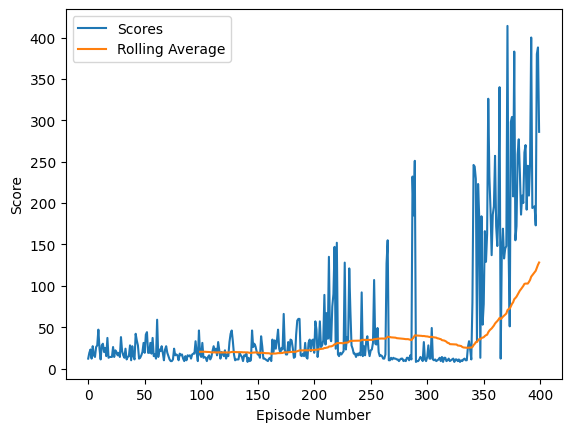

In [9]:
scores = pd.Series(scores, name="scores")
scores.describe()
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="Scores")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("Score")